<a href="https://colab.research.google.com/github/jjwood3/hello-world/blob/master/Copy_of_pairs_trading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://news.illinois.edu/files/6367/543635/116641.jpg" alt="University of Illinois" width="250"/>

## Project 1: Pairs Trading ##

### Due 2021-Feb-05 23:59:59 CST###

Project submission by group (optimally 4 people, please list all your group members below, with names and email addresses)
* John Doe <johndoe@illinois.edu>
* Jane Roe <janeroe@illinois.edu>

Note 0:  Anaconda Python <https://www.anaconda.com/distribution/> is a strong implementation of python.

Note 1: Suggest using Google Colab to work in groups. Google colab is a sharable type of Jupyter Notebook. To work on google colab, first save a copy of this file to your own drive using **File>Save a copy in Drive** and share the saved copy among group members. (Be sure to log on Google colab and Google Drive with your Illinois Google account. Please refer to https://itservices.illinois.edu/services/google-apps-illinois/details for more information of your Illinois Google account).

Note 2: For submission, please do the following two steps, both before the due time **(late submissions are not acceptable)**:

*   Download the finished notebook as an **.ipynb** file and upload the file to Gradescope (one upload per group will be enough, please ignore the Autograder if you see it when uploading)
*   (If using Google Colab) Send a sharable link to me via email: <qiz2@illinois.edu> (one email per group will be enough)



### imports and graphics configurations ###

IE 525 Group Members:



*   Wes Cravens wbc3@illinois.edu
*   Zicheng Wei wei41@illinois.edu
*   Jacob Wood jjwood3@illinois.edu
*   Zhou Yi yizhou16@illinois.edu





In [ ]:
import numpy as np
import io
import os
import pandas as pd
import pandas
import time
import random
import matplotlib as plt
import scipy.stats
import matplotlib.offsetbox as offsetbox
from matplotlib.ticker import StrMethodFormatter

#%matplotlib notebook
import scipy.stats
from pandas.plotting import autocorrelation_plot
import matplotlib.offsetbox as offsetbox
from matplotlib.ticker import StrMethodFormatter
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()


def saver(fname):
    plt.savefig(fname+".png",bbox_inches="tight")
    
def legend(pos="bottom",ncol=3,extra=False):
    if pos=="bottom":
        extra = 0.15 if extra else 0
        plt.legend(bbox_to_anchor=(0.5,-0.2-extra), loc='upper center',facecolor="lightgray",ncol=ncol)
    elif pos=="side":
        plt.legend(bbox_to_anchor=(1.1,0.5), loc='center left',facecolor="lightgray",ncol=1)
        
def textbox(txt,fname=None):
    plt.figure(figsize=(1,1))
    plt.gca().add_artist(offsetbox.AnchoredText("\n".join(txt), loc="center",prop=dict(size=30)))
    plt.axis('off')
    if fname is not None:
        saver(fname)
    plt.show()
    plt.close()


In [ ]:
#for some reason, this needs to be in a separate cell
params={
    "font.size":15,
    "lines.linewidth":5,
}
plt.pyplot.rcParams.update(params)

In [ ]:
pngfiles=[f for f in os.listdir(".") if f.endswith(".png")]
print("existing png files: "+str(pngfiles))
print([os.remove(f) for f in pngfiles])

existing png files: []
[]


In [ ]:
def getfile(location_pair,**kwargs): #tries to get local version and then defaults to google drive version
    (loc,gdrive)=location_pair
    try:
        out=pandas.read_csv(loc,**kwargs)
    except FileNotFoundError:
        print("local file not found; accessing Google Drive")
        loc = 'https://drive.google.com/uc?export=download&id='+gdrive.split('/')[-2]
        out=pandas.read_csv(loc,**kwargs)
    return out

# **Pairs Trading (30 pts)** #

Please use the data (Jan-02-2019 to Dec-30-2020) for General Motors Company (NYSE: GM) and Ford Motor Company (NTSE: F) to complete the following two tasks. 

Data for Ford: https://drive.google.com/file/d/1_GprTKCcZH6S3cuWdGJoQHTmS4YuKWpM/view?usp=sharing 

Data for GM: https://drive.google.com/file/d/14gL6c8rDCKIH6zdoN4Vl1w8DZMXOlF2y/view?usp=sharing

(Data Source: Yahoo Finance)

**Task 1 (Cointegration):** Is it better to regress F on GM, or GM on F?  This is an open-ended question with no fixed correct answer. I wish you to investigate, come to a conclusion, and defend it. Please include code and also your analysis. (15 pts)

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving F.csv to F.csv
Saving GM.csv to GM.csv


In [ ]:
#Constants:
ticker_A="F"
ticker_B="GM"

color_A="red"
color_B="blue"

In [ ]:
#Define the two data sets for Ford and GM
data_A = pd.read_csv(io.BytesIO(uploaded['F.csv'])).set_index("Date",drop=True)
data_A.index = pandas.to_datetime(data_A.index)



data_B = pd.read_csv(io.BytesIO(uploaded["GM.csv"])).set_index("Date",drop=True)
data_B.index = pandas.to_datetime(data_B.index)

#Define the adjusted closing price for Ford
adj_A = pandas.Series(data_A["Adj Close"])

#Define the adjusted closing price for GM
adj_B = pandas.Series(data_B["Adj Close"])


## read in data

In [ ]:
#Display the first 10 rows of Ford
print(data_A.head(10))



            Open  High   Low  Close  Adj Close    Volume
Date                                                    
2019-01-02  7.53  8.02  7.48   7.90   7.157524  47494400
2019-01-03  7.97  7.99  7.78   7.78   7.048802  39172400
2019-01-04  7.91  8.12  7.85   8.08   7.320606  43039800
2019-01-07  8.11  8.37  8.03   8.29   7.510870  40729400
2019-01-08  8.42  8.54  8.35   8.37   7.583352  45644000
2019-01-09  8.45  8.77  8.36   8.72   7.900456  48404900
2019-01-10  8.71  8.77  8.45   8.67   7.855156  39490400
2019-01-11  8.77  8.93  8.70   8.82   7.991058  41559900
2019-01-14  8.80  9.06  8.76   8.99   8.145081  44833800
2019-01-15  9.02  9.03  8.75   8.84   8.009178  65311700


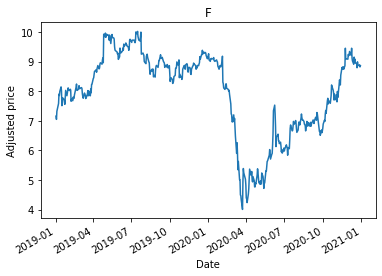

In [ ]:
#Plot the adjusted closing price for Ford
plt.figure()
plt.plot(adj_A.index,adj_A,label=ticker_A)
plt.ylabel("Adjusted price")
plt.xlabel("Date")
plt.title(ticker_A)
plt.gcf().autofmt_xdate()
saver("tickerA")
plt.show()
plt.close()

```
# This is formatted as code
```

### guess an upward trend ###

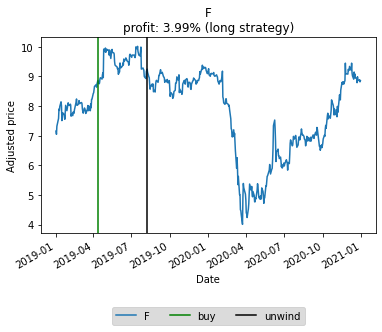

In [ ]:
enter_index=70
unwind_index=150
profit=(adj_A[unwind_index]/adj_A[enter_index]-1)
title_str="{}\nprofit: {:.2f}% (long strategy)".format(ticker_A,profit*100)
plt.figure()
plt.plot(adj_A.index,adj_A,label=ticker_A)
plt.axvline(adj_A.index[enter_index],color="green",label="buy")
plt.axvline(adj_A.index[unwind_index],color="black",label="unwind")
plt.ylabel("Adjusted price")
plt.xlabel("Date")
plt.title(title_str)
plt.gcf().autofmt_xdate()
legend("bottom",extra=True)
saver("long")
plt.show()
plt.close()


### guess a downward trend ###

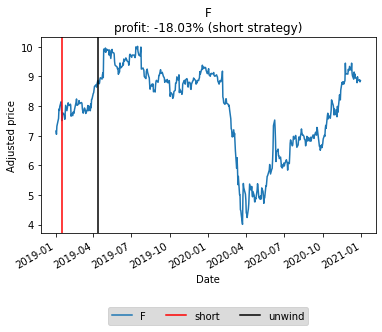

In [ ]:
enter_index=10
unwind_index=70
profit=-(adj_A[unwind_index]/adj_A[enter_index]-1)
title_str="{}\nprofit: {:.2f}% (short strategy)".format(ticker_A,profit*100)
plt.figure()
plt.plot(adj_A.index,adj_A,label=ticker_A)
plt.axvline(adj_A.index[enter_index],color="red",label="short")
plt.axvline(adj_A.index[unwind_index],color="black",label="unwind")
plt.ylabel("Adjusted price")
plt.xlabel("Date")
plt.title(title_str)
plt.gcf().autofmt_xdate()
legend("bottom",extra=True)
saver("short")
plt.show()
plt.close()

### loss on long strategy

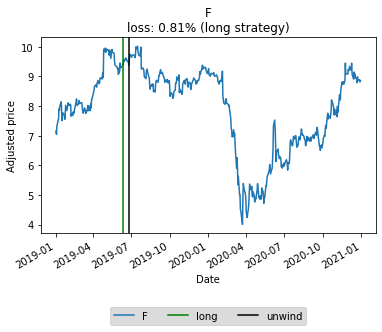

In [ ]:
enter_index=110
unwind_index=120
profit=(adj_A[unwind_index]/adj_A[enter_index]-1)
title_str="{}\nloss: {:.2f}% (long strategy)".format(ticker_A,-profit*100)
plt.figure()
plt.plot(adj_A.index,adj_A,label=ticker_A)
plt.axvline(adj_A.index[enter_index],color="green",label="long")
plt.axvline(adj_A.index[unwind_index],color="black",label="unwind")
plt.ylabel("Adjusted price")
plt.xlabel("Date")
plt.title(title_str)
plt.gcf().autofmt_xdate()
legend("bottom",extra=True)
saver("long_loss")
plt.show()
plt.close()

### loss on short strategy


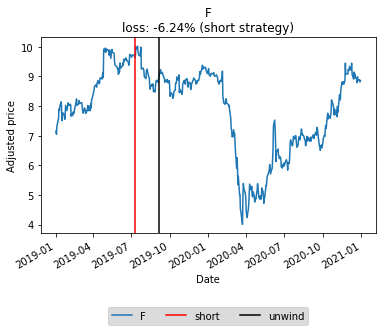

In [ ]:
enter_index=130
unwind_index=170
profit=-(adj_A[unwind_index]/adj_A[enter_index]-1)
title_str="{}\nloss: {:.2f}% (short strategy)".format(ticker_A,-profit*100)
plt.figure()
plt.plot(adj_A.index,adj_A,label=ticker_A)
plt.axvline(adj_A.index[enter_index],color="red",label="short")
plt.axvline(adj_A.index[unwind_index],color="black",label="unwind")
plt.ylabel("Adjusted price")
plt.xlabel("Date")
plt.title(title_str)
plt.gcf().autofmt_xdate()
legend("bottom",extra=True)
saver("short_loss")
plt.show()
plt.close()

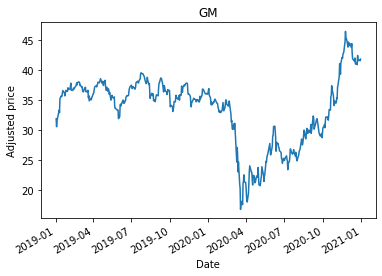

In [ ]:

plt.figure()
plt.plot(adj_B.index,adj_B,label=ticker_B)
plt.ylabel("Adjusted price")
plt.xlabel("Date")
plt.title(ticker_B)
plt.gcf().autofmt_xdate()
saver("tickerB")
plt.show()
plt.close()

## Compare the stocks

In [ ]:
#trading days are different in different countries
joined_data=pandas.concat([adj_A,adj_B],axis="columns").dropna(axis="index")
print(joined_data.head())
(adj_A,adj_B)=(joined_data[ticker_A], joined_data[ticker_B])

            Adj Close  Adj Close
Date                            
2019-01-02   7.157524  31.893360
2019-01-03   7.048802  30.575533
2019-01-04   7.320606  31.599455
2019-01-07   7.510870  32.575977
2019-01-08   7.583352  33.002617


KeyError: ignored

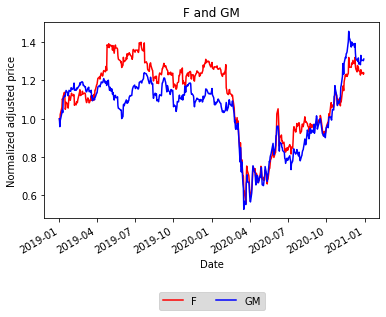

In [ ]:
normalized_A=adj_A/adj_A[0]
normalized_B=adj_B/adj_B[0]

plt.figure()
plt.plot(normalized_A.index,normalized_A,label=ticker_A,color=color_A)
plt.plot(normalized_B.index,normalized_B,label=ticker_B,color=color_B)
plt.ylabel("Normalized adjusted price")
plt.xlabel("Date")
plt.title(ticker_A+" and "+ticker_B)
plt.gcf().autofmt_xdate()
legend("bottom",extra=True)
saver("pair")
plt.show()
plt.close()

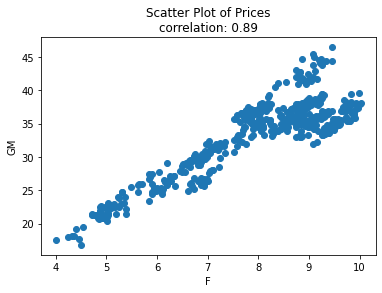

In [ ]:
corr,_=scipy.stats.pearsonr(adj_A,adj_B)
title_str="Scatter Plot of Prices\ncorrelation: {:.2f}".format(corr)
plt.scatter(adj_A,adj_B)
plt.xlabel(ticker_A)
plt.ylabel(ticker_B)
plt.title(title_str)
saver("scatter")
plt.show()
plt.close()

## regression

Regress GM on F

slope: 3.5729920014660546
intercept: 5.019331144153952
Date
2019-01-02    1.300253
2019-01-03    0.370889
2019-01-04    0.423657
2019-01-07    0.720367
2019-01-08    0.888030
Name: residual, dtype: float64


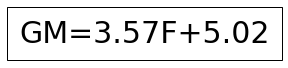

In [ ]:
slope, intercept, _,_,_= scipy.stats.linregress(
    adj_A,adj_B)
print("slope: "+str(slope))
print("intercept: "+str(intercept))
#portfolio=adj_B-adj_A*slope-intercept
#portfolio.name="Portfolio"
residual=adj_B-(intercept+adj_A*slope)
residual.name="residual"
print(residual.head())

text=[]
text.append("{0:}={1:.2f}{2:}{3:+.2f}".format(ticker_B,slope,ticker_A,intercept))
fig,ax=plt.subplots(figsize=(1,1))
ax.add_artist(offsetbox.AnchoredText("\n".join(text), loc="center",prop=dict(size=30)))
ax.axis('off')
saver("regress_formula")
plt.show()
plt.close()


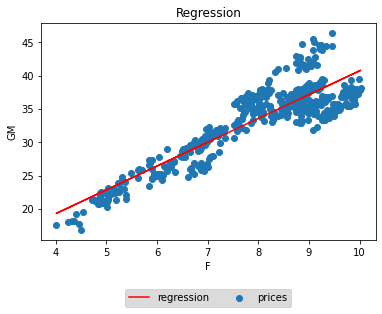

In [ ]:
plt.scatter(adj_A,adj_B,label="prices")
plt.plot(adj_A,intercept+adj_A*slope,color="red",label="regression")
plt.xlabel(ticker_A)
plt.ylabel(ticker_B)
plt.title("Regression")
legend("bottom")
saver("regression")
plt.show()
plt.close()

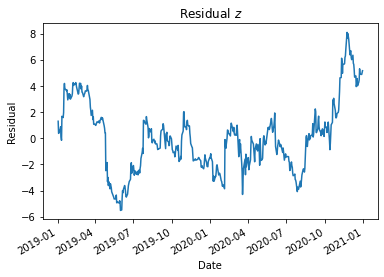

In [ ]:
plt.figure()
plt.plot(residual.index,residual,label="signal")
plt.ylabel("Residual")
plt.xlabel("Date")
plt.title(r"Residual $z$")
plt.gcf().autofmt_xdate()
saver("residual")
plt.show()
plt.close()

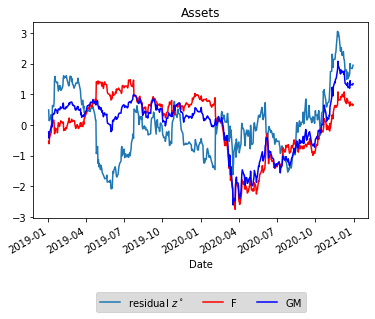

In [ ]:
plt.figure()
plt.plot(residual.index,residual/residual.std(),label=r"residual $z^\circ$")
plt.plot(normalized_A.index,(normalized_A-normalized_A.mean())/normalized_A.std(),label=ticker_A,color=color_A)
plt.plot(normalized_B.index,(normalized_B-normalized_B.mean())/normalized_A.std(),label=ticker_B,color=color_B)
#plt.ylabel("")
plt.xlabel("Date")
plt.title("Assets")
plt.gcf().autofmt_xdate()
legend("bottom",extra=True)
saver("assets")
plt.show()
plt.close()

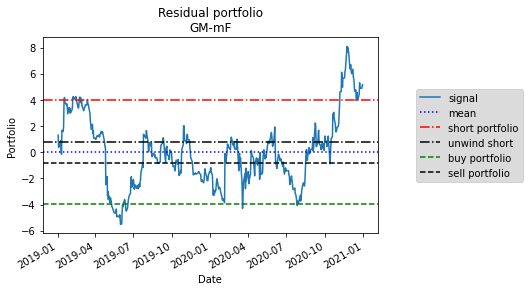

In [ ]:
residual_mean=residual.mean()
residual_std=residual.std()

plt.figure()
plt.plot(residual.index,residual,label="signal")
plt.axhline(residual_mean,color="blue",linestyle=":",label="mean")
plt.axhline(residual_mean+1.5*residual_std,color="red",linestyle="-.",label="short portfolio")
plt.axhline(residual_mean+0.3*residual_std,linestyle="-.",color="black",label="unwind short")
plt.axhline(residual_mean-1.5*residual_std,color="green",linestyle="--",label="buy portfolio")
plt.axhline(residual_mean-0.3*residual_std,linestyle="--",color="black",label="sell portfolio")
plt.ylabel("Portfolio")
plt.xlabel("Date")
title=[]
title.append("Residual portfolio")
title.append("{0:s}-m{1:s}".format(ticker_B,ticker_A))
plt.title("\n".join(title))
plt.gcf().autofmt_xdate()
legend("side")
saver("residual_strategy")
plt.show()
plt.close()

Regress F on GM


slope: 0.21988648603400657
intercept: 0.593925632105254
Date
2019-01-02   -0.449320
2019-01-03   -0.268270
2019-01-04   -0.221613
2019-01-07   -0.246073
2019-01-08   -0.267403
Name: residual, dtype: float64


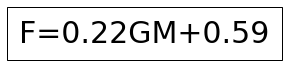

In [ ]:
slope, intercept, _,_,_= scipy.stats.linregress(
    adj_B,adj_A)
print("slope: "+str(slope))
print("intercept: "+str(intercept))

residual=adj_A-(intercept+adj_B*slope)
residual.name="residual"
print(residual.head())

text=[]
text.append("{0:}={1:.2f}{2:}{3:+.2f}".format(ticker_A,slope,ticker_B,intercept))
fig,ax=plt.subplots(figsize=(1,1))
ax.add_artist(offsetbox.AnchoredText("\n".join(text), loc="center",prop=dict(size=30)))
ax.axis('off')
saver("regress_formula")
plt.show()
plt.close()


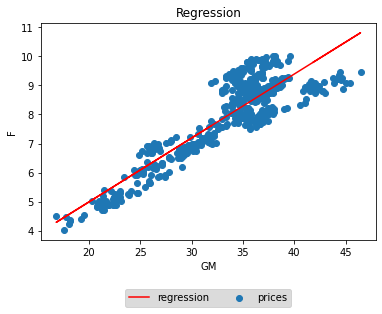

In [ ]:
plt.scatter(adj_B,adj_A,label="prices")
plt.plot(adj_B,intercept+adj_B*slope,color="red",label="regression")
plt.xlabel(ticker_B)
plt.ylabel(ticker_A)
plt.title("Regression")
legend("bottom")
saver("regression")
plt.show()
plt.close()

**Task 2 (Backtesting):** Construct a pairs trading strategy F on GM from 2019 data.  Test how it works on 2020 data. (15 pts)